## Problem: 
We give three data science questions to be answered – pick at least one of them!

For an online retailer (dataset is available under https://www.kaggle.com/mashlyn/online-retail-iiuci),
we want to know:
- Predict the weekly aggregated sales for four weeks in advance.
- Make a model, which allows estimating if a given customer will buy again something from the online shop in the next quarter.
- What products are likely to land together in the basket (i.e. which product can be recommended as a second article in the basket, if there has already an product be placed).For an online retailer, we have to solve three Questions Krebs diagnostizieren

In [1]:
# Matplotlib config
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
%config InlineBackend.rc = {'figure.figsize': (5.0, 3.0)}

import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
df = pd.read_csv("../7Lytix/online_retail_II.csv")
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


**Data** <br>
After reading in the data, i try to get a better unterstanding of the data. So i will run some basic pandas operations.

In [3]:
print(df.shape)
df.isnull().sum()

(1067371, 8)


Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

The most important information I got: There are null values in the "Description" and "Customer ID" columns. Since Description is linked with the StockCode, which is uniquely assigned to each distinct product, the column has no practial use case and i could easily drop it to get a more compact data frame. With CustomerID there is a different situation. In one Task i need explicitly the customer per order, but in two tasks it is just fine that i can assign the products to a specific order with the invoice number

## Task 1: Predict the weekly aggregated sales for four weeks in advance.

The first step is that i copy my dataframe (because if something gets wrong i do not have to import the data again) and manipulate it, so i can use it for this specific task!


In [4]:
data = df.copy()
data["TotalPrice"] = data["Quantity"]*data["Price"]
data = data.drop(['Description', 'Country'], axis=1)
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data = data[~data["Invoice"].str.contains("C", na = False)]
data = data[~data["Invoice"].str.contains("A", na = False)]
data = data.groupby("Invoice", as_index=False).agg({"TotalPrice":"sum", "InvoiceDate":"max"}).sort_values("Invoice", ascending = True)
data["Y-W"]= data['InvoiceDate'].dt.strftime('%G-%V')
data.head()

,Invoice,TotalPrice,InvoiceDate,Y-W
0,489434,505.30,2009-12-01 07:45:00,2009-49
1,489435,145.80,2009-12-01 07:46:00,2009-49
2,489436,630.33,2009-12-01 09:06:00,2009-49
3,489437,310.75,2009-12-01 09:08:00,2009-49
4,489438,2286.24,2009-12-01 09:24:00,2009-49


Since i am only interested in aggregated sale, i dropped all Invoice numbers with a "C" (cancelled Orders) and an "A". The Invoice numbers with "A" are not described in the data information, but their price is negative so i am not interested in using them either

In [5]:
data2 = data.copy()
data2 = data2.groupby("Y-W", as_index=False).agg({"TotalPrice":"sum"}).sort_values("Y-W", ascending=True)
data2

,Y-W,TotalPrice
0,2009-49,267053.53
1,2009-50,241631.47
2,2009-51,261738.39
3,2009-52,55262.37
4,2010-01,168520.11
...,...,...
99,2011-45,370044.97
100,2011-46,388622.44
101,2011-47,316412.16
102,2011-48,324370.83


In [6]:
print(data2.max())
print(data2.min())

Y-W           2011-49
TotalPrice     583362
dtype: object
Y-W           2009-49
TotalPrice    55262.4
dtype: object


Text(0, 0.5, 'Aggregated Sales')

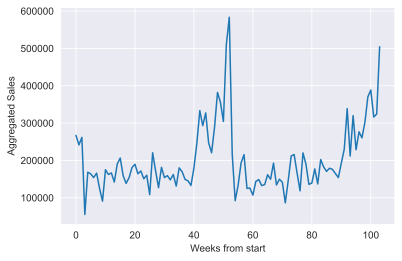

In [7]:
sns.set_style("darkgrid")
plt =sns.lineplot(data=data2, x=data2.index, y="TotalPrice")
plt.set_xlabel("Weeks from start")
plt.set_ylabel("Aggregated Sales")

After i prepared my data, I plotted a time series line plot to get a better understanding of the weekly aggregated sales. One week seemed a lot higher than expected, but it was calender week 49, which is traditional for christmas shopping, so I believe it is quite normal for an online retailer.

In [8]:
data2.iloc[data2['TotalPrice'].idxmax()]

Y-W           2010-49
TotalPrice     583362
Name: 52, dtype: object

In [9]:
y = data2["TotalPrice"]
y_train = y.iloc[0:(round(len(y)*0.8))]
y_test = y.iloc[round(len(y)*0.8):len(y)]

In [10]:
from pmdarima import auto_arima
arima_model = auto_arima(y_train, seasonal = True, m=7)

In [11]:
forecast = arima_model.predict(n_periods = 4)
print(forecast)

[154194.42155918 165324.69067878 172589.78597652 177331.9543031 ]


For the Time series Forecast I took a auto arima model which leads to the predictions above. 

## Task 2: Make a model, which allows estimating if a given customer will buy again something from the online shop in the next quarter

In this task we explicit need to identify every customer, therefor I drop all NULL values in this dataset. We also drop all cancelled order again, because we want orders and not cancellations. My Idea is, instead of labeling the whole Data with 1 and 0s i calculate the days to the next purchase and then I know if he purchased in the next quarter or not.

In [30]:
datamodel = df.copy()
datamodel = datamodel.dropna(subset = ['Customer ID'])
datamodel = datamodel[~datamodel["Invoice"].str.contains("C", na = False)]
datamodel = datamodel[~datamodel["Invoice"].str.contains("A", na = False)]
datamodel['InvoiceDate'] = pd.to_datetime(datamodel['InvoiceDate'])
datamodel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 805620 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      805620 non-null  object        
 1   StockCode    805620 non-null  object        
 2   Description  805620 non-null  object        
 3   Quantity     805620 non-null  int64         
 4   InvoiceDate  805620 non-null  datetime64[ns]
 5   Price        805620 non-null  float64       
 6   Customer ID  805620 non-null  float64       
 7   Country      805620 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 55.3+ MB


After the first data manipulation I split the dataset. Since wie do not need the last quarter for training my model.

In [31]:
dtm = datamodel[(datamodel['InvoiceDate']<pd.Timestamp(2011,9,1))].reset_index(drop=True)
dtm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634183 entries, 0 to 634182
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      634183 non-null  object        
 1   StockCode    634183 non-null  object        
 2   Description  634183 non-null  object        
 3   Quantity     634183 non-null  int64         
 4   InvoiceDate  634183 non-null  datetime64[ns]
 5   Price        634183 non-null  float64       
 6   Customer ID  634183 non-null  float64       
 7   Country      634183 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 38.7+ MB


In [32]:
dtm_last = datamodel[(datamodel['InvoiceDate']>=pd.Timestamp(2011,9,1))].reset_index(drop=True)
dtm_last.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171437 entries, 0 to 171436
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      171437 non-null  object        
 1   StockCode    171437 non-null  object        
 2   Description  171437 non-null  object        
 3   Quantity     171437 non-null  int64         
 4   InvoiceDate  171437 non-null  datetime64[ns]
 5   Price        171437 non-null  float64       
 6   Customer ID  171437 non-null  float64       
 7   Country      171437 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 10.5+ MB


After I split the Frame, i need to create features to predict if the Customer buys in the next quarter, and add the next purchase

In [33]:
features = pd.DataFrame(dtm['Customer ID'].unique())
features.columns = ['Customer ID']
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5251 entries, 0 to 5250
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Customer ID  5251 non-null   float64
dtypes: float64(1)
memory usage: 41.1 KB


Create some help Dataframes for the next purchases 

In [34]:
help1 = dtm_last.groupby('Customer ID').InvoiceDate.min().reset_index()
help1.columns = ['Customer ID', 'MinDate']
help2 = dtm.groupby('Customer ID').InvoiceDate.max().reset_index()
help2.columns =['Customer ID','MaxDate']
help3 = pd.merge(help2, help1, on ='Customer ID', how = 'left')
help3['NextPurchase'] = (help3['MinDate']-help3['MaxDate']).dt.days
help3

,Customer ID,MaxDate,MinDate,NextPurchase
0,12346.0,2011-01-18 10:01:00,NaT,NaN
1,12347.0,2011-08-02 08:48:00,2011-10-31 12:25:00,90.0
2,12348.0,2011-04-05 10:47:00,2011-09-25 13:13:00,173.0
3,12349.0,2010-10-28 08:23:00,2011-11-21 09:51:00,389.0
4,12350.0,2011-02-02 16:01:00,NaT,NaN
...,...,...,...,...
5246,18283.0,2011-07-14 13:20:00,2011-09-05 12:35:00,52.0
5247,18284.0,2010-10-04 11:33:00,NaT,NaN
5248,18285.0,2010-02-17 10:24:00,NaT,NaN
5249,18286.0,2010-08-20 11:57:00,NaT,NaN


In [35]:
features = pd.merge(features, help3[['Customer ID', 'NextPurchase']], on = 'Customer ID', how = 'left')
features = features.fillna(4444)
features

,Customer ID,NextPurchase
0,13085.0,4444.0
1,13078.0,20.0
2,15362.0,4444.0
3,18102.0,27.0
4,12682.0,15.0
...,...,...
5246,15866.0,4444.0
5247,14660.0,14.0
5248,13726.0,61.0
5249,15690.0,96.0


**Features**
I will try to use three different features, how often a customer bought, Revenue per Customer and how recent a customer spend his money.

In [37]:
help4 = datamodel.groupby('Customer ID').InvoiceDate.count().reset_index()
help4.columns = ['Customer ID', 'Frequenz']
help5 = dtm.groupby('Customer ID').InvoiceDate.max().reset_index()
help5.columns = ['Customer ID', 'Recent']
help5['RecentDays'] = (help5['Recent'].max()-help5['Recent']).dt.days
datamodel['TotalPrice'] = datamodel['Price']*datamodel['Quantity']
help6 = datamodel.groupby('Customer ID').TotalPrice.sum().reset_index()
features = pd.merge(features, help4, on='Customer ID')
features = pd.merge(features, help5, on = 'Customer ID')
features = pd.merge(features, help6, on = 'Customer ID')
features.head()

,Customer ID,NextPurchase,Frequenz,Recent,RecentDays,TotalPrice
0,13085.0,4444.0,84,2011-07-05 12:11:00,57,2433.28
1,13078.0,20.0,801,2011-08-25 10:16:00,6,29532.45
2,15362.0,4444.0,40,2010-09-17 10:37:00,348,613.08
3,18102.0,27.0,1058,2011-08-05 15:39:00,26,608821.65
4,12682.0,15.0,1039,2011-08-31 12:18:00,0,24033.91


In [43]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [45]:
y = features['NextPurchase']
X = features[['Frequenz', 'TotalPrice', 'RecentDays']]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, random_state=42)
sc = StandardScaler()
sc.fit(X_train)

StandardScaler()

In [67]:
model = SVC(kernel = "rbf", C = 7, gamma = 5)
#model = GridSearchCV(SVC(), param_grid = {
 #   "kernel": ["rbf"], 
  #  "C": [0.01, 0.05, 0.1, 0.5, 1, 5, 7, 10], 
   # "gamma": [0.01, 0.05, 0.1, 0.5, 1, 5, 10]
#}, cv = RepeatedKFold(), n_jobs = 8)
model.fit(sc.transform(X_train), y_train)

SVC(C=7, gamma=5)

In [68]:
print(model.score(sc.transform(X_train), y_train))
print(model.score(sc.transform(X_test), y_test))

0.6084306754697816
0.543031226199543


In [69]:
xgb_model = xgb.XGBClassifier(eval_metric='logloss').fit(X_train, y_train)

C:\Users\jschl\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [71]:
print(xgb_model.score(X_train, y_train))
print(xgb_model.score(X_test, y_test))

0.8849669883189436
0.5209444021325209


In [72]:
p_grid_search = GridSearchCV(
        estimator = xgb.XGBClassifier(eval_metric='mlogloss'), 
        param_grid = {
    'max_depth':range(3,10,2), 
    'min_child_weight':range(1,5,2)
    }, 
        scoring='accuracy', 
        n_jobs=-1, 
        iid=False, 
        cv=2
    )

p_grid_search.fit(X_train, y_train)
p_grid_search.best_params_, p_grid_search.best_score_

C:\Users\jschl\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\jschl\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
C:\Users\jschl\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


({'max_depth': 5, 'min_child_weight': 3}, 0.5436769933976637)

In [79]:
xgb_model = xgb.XGBClassifier(
 eval_metric='logloss', 
 max_depth=list(p_grid_search.best_params_.values())[0]-1, 
 min_child_weight=list(p_grid_search.best_params_.values())[-1]+6
 ).fit(X_train, y_train)

In [80]:
print(xgb_model.score(X_train, y_train))
print(xgb_model.score(X_test, y_test))

0.5551041137633317
0.5491241431835491


I tried a SVM and xgboost for this kind of Task, but my model score is not that great. Which means i probably have the wrong features. But i do not have a lot of experience with retail, which also means i do not know what accuracy i should expect in retail.

## Task 3: What products likley land together in the basket

For this analyis we are going to use the Apriori Algorithm, which is not the most performant algorithm. But it should work with our dataset quite well.
First I going to manipulate my data, i cut all cancelled orders and dropped all NA values

In [113]:
import apyori
import mlxtend.preprocessing
from  mlxtend.frequent_patterns import apriori, association_rules

In [114]:
mba = df.copy()
mba = mba[~mba["Invoice"].str.contains("C", na = False)]
mba= mba[~mba["Invoice"].str.contains("A", na = False)]
mba = mba.dropna(subset = ['Customer ID'])
mba.isnull().any()

Invoice        False
StockCode      False
Description    False
Quantity       False
InvoiceDate    False
Price          False
Customer ID    False
Country        False
dtype: bool

In [100]:
mbawork = mba.groupby(['Invoice', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('Invoice')
mbawork.head()

Description,DOORMAT UNION JACK GUNS AND ROSES,3 STRIPEY MICE FELTCRAFT,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,ANIMAL STICKERS,BLACK PIRATE TREASURE CHEST,BROWN PIRATE TREASURE CHEST,Bank Charges,CAMPHOR WOOD PORTOBELLO MUSHROOM,CHERRY BLOSSOM DECORATIVE FLASK,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
Invoice,,,,,,,,,,,,,,,,,,,,,
489434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
489435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
489436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
489437,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
489438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


I transforemd the Basket Data, to a table which contains the information of each quantity per product is bought per transaction. Because the quantity is for our analysis not important, only if a product is bought or not. I encode the table, where if a item was bought it turns 1 and else a 0.

In [102]:
def encode(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

mbawork_encode = mbawork.applymap(encode)
mbawork_encode

Description,DOORMAT UNION JACK GUNS AND ROSES,3 STRIPEY MICE FELTCRAFT,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,ANIMAL STICKERS,BLACK PIRATE TREASURE CHEST,BROWN PIRATE TREASURE CHEST,Bank Charges,CAMPHOR WOOD PORTOBELLO MUSHROOM,CHERRY BLOSSOM DECORATIVE FLASK,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
Invoice,,,,,,,,,,,,,,,,,,,,,
489434,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489435,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489436,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489437,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489438,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581583,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581584,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581585,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


After i have done this, i am able to apply the apriori algorihm

In [125]:
frequent_items = apriori(mbawork_encode, min_support = 0.015, use_colnames = True).sort_values('support', ascending = False).reset_index(drop = True)
frequent_items['length'] = frequent_items['itemsets'].apply(lambda x: len(x))

In [128]:
association_rules(frequent_items, metric = 'lift', min_threshold = 1).sort_values('lift', ascending = False).reset_index(drop=True)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.020176,0.025233,0.016903,0.837802,33.202266,0.016394,6.009719
1,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.025233,0.020176,0.016903,0.669882,33.202266,0.016394,2.968104
2,(ROSES REGENCY TEACUP AND SAUCER ),(PINK REGENCY TEACUP AND SAUCER),0.028560,0.020176,0.016146,0.565341,28.020751,0.015570,2.254236
3,(PINK REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.020176,0.028560,0.016146,0.800268,28.020751,0.015570,4.863721
4,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.025233,0.028560,0.020095,0.796356,27.883766,0.019374,4.770282
...,...,...,...,...,...,...,...,...,...
73,(WHITE HANGING HEART T-LIGHT HOLDER),(HOME BUILDING BLOCK WORD),0.132197,0.049520,0.015957,0.120704,2.437478,0.009410,1.080955
74,(WHITE HANGING HEART T-LIGHT HOLDER),(HEART OF WICKER SMALL),0.132197,0.048114,0.015389,0.116408,2.419431,0.009028,1.077291
75,(HEART OF WICKER SMALL),(WHITE HANGING HEART T-LIGHT HOLDER),0.048114,0.132197,0.015389,0.319843,2.419431,0.009028,1.275885
76,(WHITE HANGING HEART T-LIGHT HOLDER),(ASSORTED COLOUR BIRD ORNAMENT),0.132197,0.071724,0.017525,0.132570,1.848326,0.008044,1.070144


With this associations we can see that Pink Regency Teacup and Saucer and Green Regency Teacup and Saucer are often bought together